In [43]:
#import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
from scipy.special import inv_boxcox

import pickle
import joblib

In [3]:
def grangers_test(data, maxlag, variables, test='ssr_chi2test',verbose=False):
    """Les valeurs dans le df sont les p-valeurs
    L'hypothèse H0 de notre test est la suivant :
        "Les prédictions de la série X n'influence pas les prédictions de la série Y"
    Ce qui signifie qu'une p-valeur inférieure à 0.05 rejette l'hypothèse H0 et incite à garder ce couple de valeurs
    Comme on s'intéresse à la prédiciton de la variable 1, on ne va jamais l'abandonner

Les arguments sont :
    Data, le DF de nos valeurs
    maxlag, le fameux maxlag pour le nombre de paramètres dans l'équation'
    variables : une list qui contient le nom des variables c'est à dire le nom de nos colonnes'
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for col in df.columns:
        for row in df.index:
            test_result = grangercausalitytests(data[[row, col]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)] #on va avoir toutes les p-valeurs une part lag
            min_p_value = np.min(p_values) #On s'intéresse à la valeur minimale des p-valeur
            df.loc[row, col] = min_p_value
    df.columns = [var + '_X' for var in variables]
    df.index = [var + '_Y' for var in variables]
    return df


In [4]:
def dickey_fuller_test(data, seuil_signif=0.05, name='', verbose=False):
    """On conduit un test de Dick-Fuller sur notre data set et on imprime les résultats"""
    """On rappelle que pour rejeter l'hypothèse H0 il faut que la p-value soit inférieur au seuil choisi, ici 0.05"""
    result = adfuller(data, autolag='AIC')
    output = {'statistique_du_test':round(result[0], 4), 'p_value':round(result[1], 4), 'n_lags':round(result[2], 4), 'n_obs':result[3]}
    p_value = output['p_value']

    # Print Summary
    print(f'    Test de Dick-Fuller augmenté sur : "{name}"', "\n   ", '~'*47)
    print(f' Hypothèse H0: La data présente une racine unitaire, la série est Non-Stationnaire.')
    print(f' La p-value est de      : {p_value}')
    print(f' Niveau de confiance    = {seuil_signif}')
    print(f' Statistique de test    = {output["statistique_du_test"]}')
    print(f' Nombre de lags choisis = {output["n_lags"]}')

    if p_value <= seuil_signif:
        print(f" => P-Value = {p_value} <= {seuil_signif}. On rejette H0 au seuil de confiance.")
        print(f" => La série est STATIONNAIRE.")
    else:
        print(f" => P-Value = {p_value} > {seuil_signif}. On ne peut pas rejeter H0 au seuil de confiance.")
        print(f" => La série est NON stationnaire.")


# fonction predict

In [5]:
def inv_diff(df_orig, df_forecast, n_jour_cible, second_diff = False):
    columns = df_orig.columns
    df_fc_inv = df_forecast.copy()
    for col in columns:
        """
        Attention ! lorsque l'on inverse une différenciation, un récupère la "dernière donnée" à laquelle on rajoute
        la somme cumulée des valeurs différenciées.
        Dans le cas d'un array prédit, le dernier point de donnée n'est PAS le "-1" du train_set, mais le "-1-nb_jour_pred"
        Dans notre cas on va donc retourner 120 jours en arrière
        Dans le cas d'une double diff, on soustrait d'abord l'avant dernière valeur à la dernière
        """
        if second_diff:
            df_fc_inv[str(col)+'_1d'] = (df_orig[col].iloc[-n_jour_cible-1]-df_orig[col].iloc[-n_jour_cible-2]) + df_fc_inv[str(col)].cumsum()
            df_fc_inv[str(col)+'_forecast'] = df_orig[col].iloc[-n_jour_cible-1] + df_fc_inv[str(col)+"_1d"].cumsum()
        else:
            df_fc_inv[str(col)+'_forecast'] = df_orig[col].iloc[-n_jour_cible-1] + df_fc_inv[str(col)].cumsum()
    return df_fc_inv

In [6]:

#On va créer la fonction pour fit et evaluer le modèle var
def pipeline_var(model, x, y, lag, x_train_orig, n_jour_cible, cible):
    model_fitted_var = model.fit(lag, ic = "aic")
    result_normality = model_fitted_var.test_normality().pvalue #"H0 : les données suivent une loi normale. Si p-value <0.05, on rejette
    result_whiteness = model_fitted_var.test_whiteness(round((len(x) + len(y))/5)).pvalue

    #On choisit dans la formule précédente l = nb_observ/5
    #On calcule la moyenne des résidus (biais) que l'on va ajouter à nos preds

    #df_resid = model_fitted_var.resid
    #mean_resid = df_resid.mean()

    lag_order = model_fitted_var.k_ar
    input_data = x.values[-lag_order:]
    y_predicted = model_fitted_var.forecast(y = input_data, steps = len(y))
    #y_predicted = y_predicted + mean_resid #j'ajoute le biais

    """Pour le moment, nos résidus ne passent pas les tests de normalité et de bruits blancs
    Je ne peux donc pas réaliser d'intervalles de confiance classiques
    """
    #forecast_interval = model_fitted_var.forecast_interval(y = input_data, steps = len(y), alpha = 0.05)
    #df_interval_low = pd.DataFrame.from_records(forecast_interval[0] - forecast_interval[1], columns = df_diff_2.columns)
    #df_interval_up = pd.DataFrame.from_records(forecast_interval[0] + forecast_interval[2], columns = df_diff_2.columns)

    #il faudrait coder ici du conditionnel en cas de changement de metric
    df_predicted = pd.DataFrame(y_predicted, index=y.index, columns=x.columns)

    df_true_results = inv_diff(x_train_orig, df_predicted, n_jour_cible)

    #df_interval_low = inv_diff(df_orig, df_interval_low, n_jour_cible)
    #df_interval_up = inv_diff(df_orig, df_interval_up, n_jour_cible)

    #y_test_predicted = (df_true_results["Variable 1_forecast"].apply(lambda x: inv_boxcox(x,fitted_lambda[0])))
    #Sur la ligne précédente, on va détransformer la transformation cox-box en appliquant "inv boxcox" avec en paramètre le lambda associé

    #y_test_predicted_low = (df_interval_low["Spot PEG DA_forecast"].apply(lambda x: inv_boxcox(x,fitted_lambda[0])))
    #y_test_predicted_up = (df_interval_up["Spot PEG DA_forecast"].apply(lambda x: inv_boxcox(x,fitted_lambda[0])))
    #r2_var = r2_ajusted(r2_score(test_labels, y_test_predicted), x)


    #calcul MAE faux ! doit prendre en compte l'origine
    MAE_var = mean_absolute_error(y[cible], df_true_results[cible+'_forecast'])

    return df_true_results, MAE_var, result_normality, result_whiteness

In [7]:
df = pd.read_csv('./dataset/historic_demand_2009_2023_noNaN.csv')


In [8]:
df['settlement_date'] = pd.to_datetime(df['settlement_date'])

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245924 entries, 0 to 245923
Data columns (total 19 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   settlement_date            245924 non-null  datetime64[ns]
 1   settlement_period          245924 non-null  int64         
 2   period_hour                245924 non-null  object        
 3   nd                         245924 non-null  int64         
 4   tsd                        245924 non-null  int64         
 5   england_wales_demand       245924 non-null  int64         
 6   embedded_wind_generation   245924 non-null  int64         
 7   embedded_wind_capacity     245924 non-null  int64         
 8   embedded_solar_generation  245924 non-null  int64         
 9   embedded_solar_capacity    245924 non-null  int64         
 10  non_bm_stor                245924 non-null  int64         
 11  pump_storage_pumping       245924 non-null  int64   

In [10]:
df = df.set_index('settlement_date')

In [11]:
df = df.drop(['settlement_period', 'period_hour'], axis = 1)

In [12]:
variable_cible = df["tsd"]

In [13]:
index_df = df.index

In [14]:
n_period_predict = 48 * 7

In [15]:
mask = (df.index > '2022-01-01')

In [16]:
df_pour_var = df.loc[mask]

In [17]:
test_labels = df_pour_var.iloc[-n_period_predict:]
index_splitted = index_df[-n_period_predict:]

In [18]:
df_pour_var = df_pour_var +1

In [19]:
df_pour_var.describe()

,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,is_holiday
count,18765.000000,18765.000000,18765.000000,18765.000000,18765.000000,18765.000000,18765.000000,18765.000000,18765.000000,18765.000000,18765.000000,18765.000000,18765.000000,18765.000000,18765.000000,18765.000000
mean,26895.545590,29921.297202,24676.924380,1824.530189,6543.814868,1381.924114,13768.114149,1.011777,230.769784,-292.789662,-390.673221,195.438956,22.747136,60.385931,101.331042,1.028137
std,6259.064161,5432.702987,5739.592321,1076.496072,6.169810,2149.324713,193.762441,0.588944,398.932318,658.826499,702.236318,726.511232,261.242704,237.029047,732.750911,0.165370
min,14880.000000,17296.000000,1.000000,202.000000,6528.000000,1.000000,13081.000000,1.000000,1.000000,-1472.000000,-1029.000000,-1075.000000,-504.000000,-584.000000,-1021.000000,1.000000
25%,21998.000000,25750.000000,20165.000000,959.000000,6546.000000,1.000000,13743.000000,1.000000,7.000000,-944.000000,-1027.000000,-425.000000,-188.000000,1.000000,-608.000000,1.000000
50%,26156.000000,29223.000000,23922.000000,1586.000000,6546.000000,1.000000,13862.000000,1.000000,10.000000,-419.000000,-677.000000,315.000000,22.000000,1.000000,167.000000,1.000000
75%,30674.000000,33278.000000,28171.000000,2544.000000,6546.000000,2285.000000,13862.000000,1.000000,299.000000,72.000000,61.000000,924.000000,247.000000,183.000000,835.000000,1.000000
max,46148.000000,47118.000000,41616.000000,5073.000000,6575.000000,9482.000000,13862.000000,37.000000,1656.000000,1507.000000,995.000000,1063.000000,500.000000,505.000000,1021.000000,2.000000


In [24]:
for name, column in df_pour_var.iteritems():
    dickey_fuller_test(column, name=column.name)
    print('\n')

C:\Users\vdistefano\AppData\Local\Temp\ipykernel_10616\154983936.py:1: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in df_pour_var.iteritems():


    Test de Dick-Fuller augmenté sur : "nd" 
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 Hypothèse H0: La data présente une racine unitaire, la série est Non-Stationnaire.
 La p-value est de      : 0.0322
 Niveau de confiance    = 0.05
 Statistique de test    = -3.0298
 Nombre de lags choisis = 45
 => P-Value = 0.0322 <= 0.05. On rejette H0 au seuil de confiance.
 => La série est STATIONNAIRE.


    Test de Dick-Fuller augmenté sur : "tsd" 
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 Hypothèse H0: La data présente une racine unitaire, la série est Non-Stationnaire.
 La p-value est de      : 0.0063
 Niveau de confiance    = 0.05
 Statistique de test    = -3.5707
 Nombre de lags choisis = 45
 => P-Value = 0.0063 <= 0.05. On rejette H0 au seuil de confiance.
 => La série est STATIONNAIRE.


    Test de Dick-Fuller augmenté sur : "england_wales_demand" 
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 Hypothèse H0: La data présente une racine unitaire, la série est No

In [22]:
df_diff_1 = df_pour_var.diff().dropna()

In [26]:
for name, column in df_diff_1.iteritems():
    dickey_fuller_test(column, name=column.name)
    print('\n')

C:\Users\vdistefano\AppData\Local\Temp\ipykernel_14048\2090533126.py:1: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in df_diff_1.iteritems():


    Test de Dick-Fuller augmenté sur : "nd" 
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 Hypothèse H0: La data présente une racine unitaire, la série est Non-Stationnaire.
 La p-value est de      : 0.0
 Niveau de confiance    = 0.05
 Statistique de test    = -27.2299
 Nombre de lags choisis = 45
 => P-Value = 0.0 <= 0.05. On rejette H0 au seuil de confiance.
 => La série est STATIONNAIRE.


    Test de Dick-Fuller augmenté sur : "tsd" 
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 Hypothèse H0: La data présente une racine unitaire, la série est Non-Stationnaire.
 La p-value est de      : 0.0
 Niveau de confiance    = 0.05
 Statistique de test    = -32.6588
 Nombre de lags choisis = 45
 => P-Value = 0.0 <= 0.05. On rejette H0 au seuil de confiance.
 => La série est STATIONNAIRE.


    Test de Dick-Fuller augmenté sur : "england_wales_demand" 
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 Hypothèse H0: La data présente une racine unitaire, la série est Non-Stationn

In [23]:
train_var = df_diff_1[:-n_period_predict]
test_var = df_diff_1[-n_period_predict:]

In [ ]:
maxlag=90
#on fit le modèle sur la data transformée
model_var = VAR(endog = train_var)
res = model_var.select_order(maxlags=maxlag)

In [ ]:
df_granger = grangers_test(df_diff_1, maxlag, variables = df_diff_1.columns)

<Axes: >

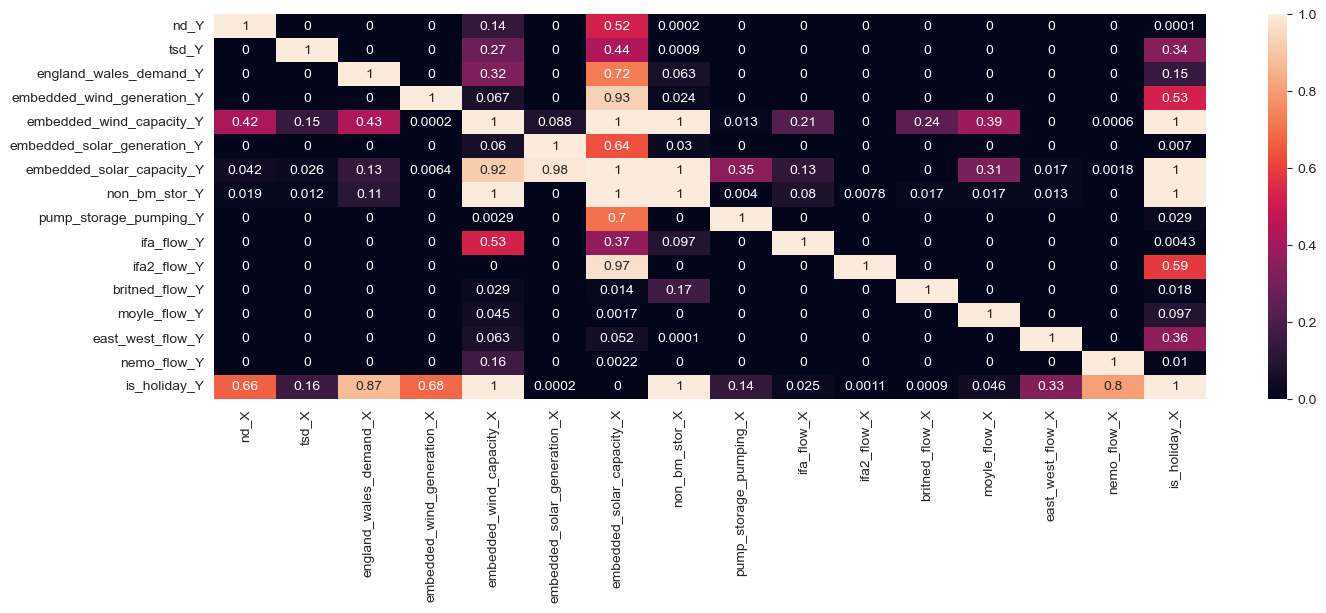

In [57]:
plt.figure(figsize = (16,5))
sns.heatmap(df_granger, annot = True)

In [ ]:
df_diff_1 = df_diff_1.drop('embedded_solar_capacity', axis = 1)

In [ ]:
df_pour_var = df_pour_var.drop('embedded_solar_capacity', axis = 1)

<Axes: >

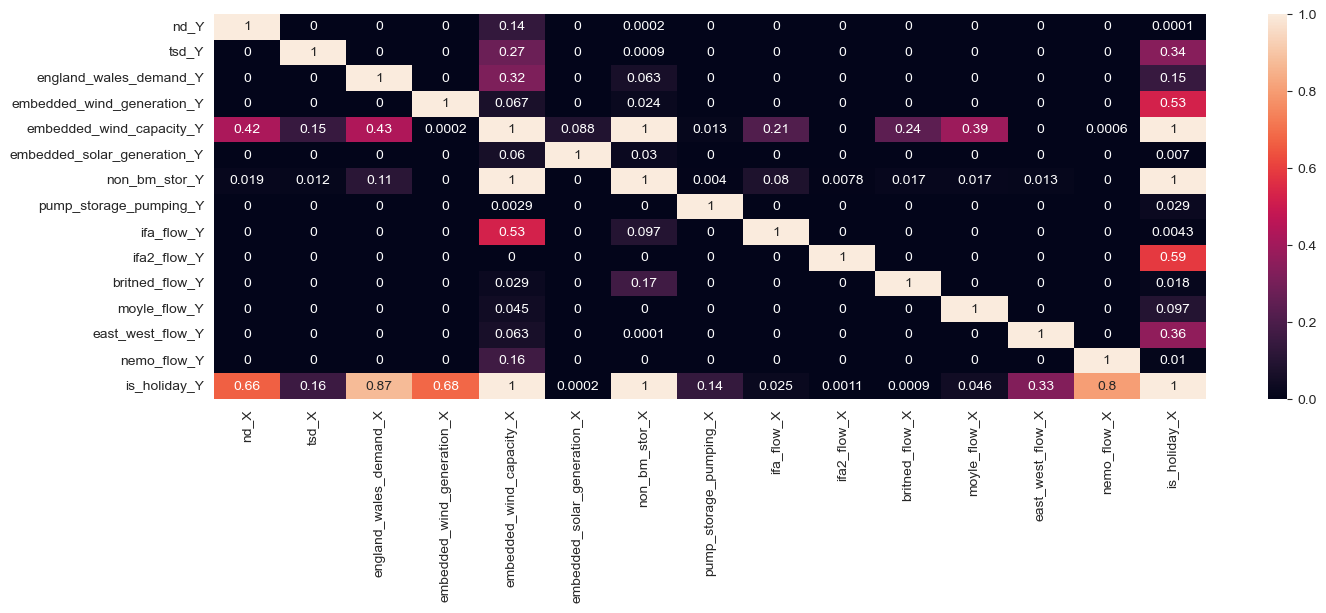

In [58]:
df_granger = grangers_test(df_diff_1, maxlag, variables = df_diff_1.columns)
plt.figure(figsize = (16,5))
sns.heatmap(df_granger, annot = True)

In [26]:
df_diff_1 = df_diff_1.drop('is_holiday', axis = 1)

In [27]:
df_pour_var = df_pour_var.drop('is_holiday', axis = 1)

<Axes: >

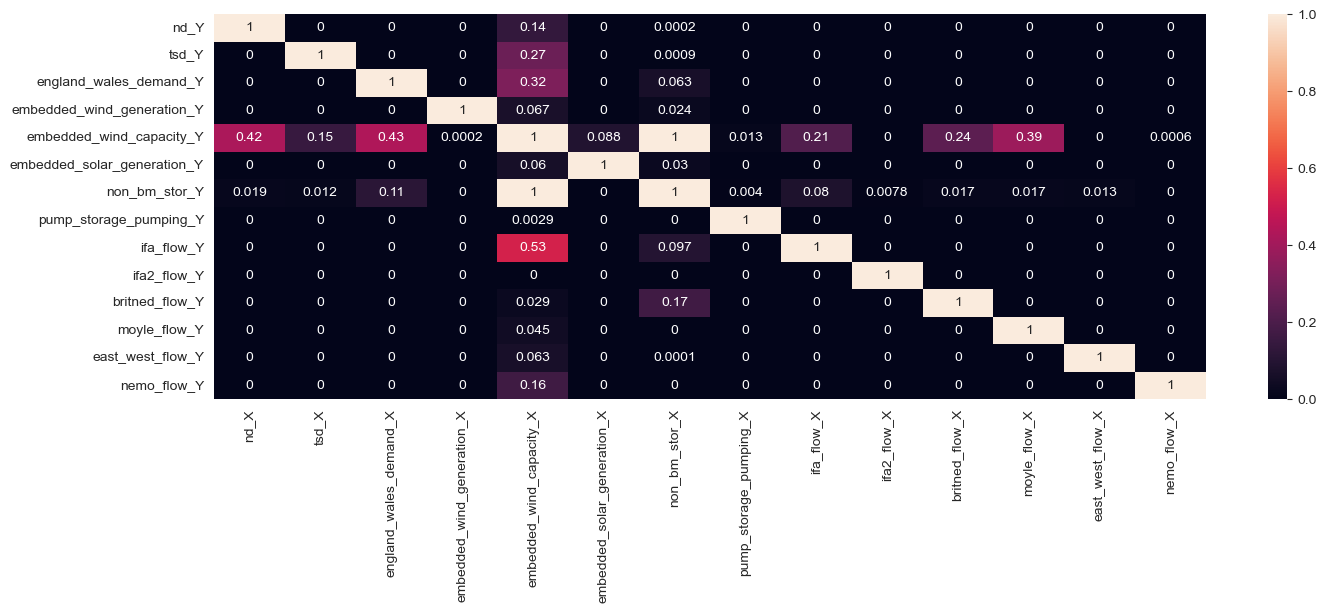

In [59]:
df_granger = grangers_test(df_diff_1, maxlag, variables = df_diff_1.columns)
plt.figure(figsize = (16,5))
sns.heatmap(df_granger, annot = True)

In [28]:
df_diff_1 = df_diff_1.drop('embedded_wind_capacity', axis = 1)

In [29]:
df_pour_var = df_pour_var.drop('embedded_wind_capacity', axis = 1)

<Axes: >

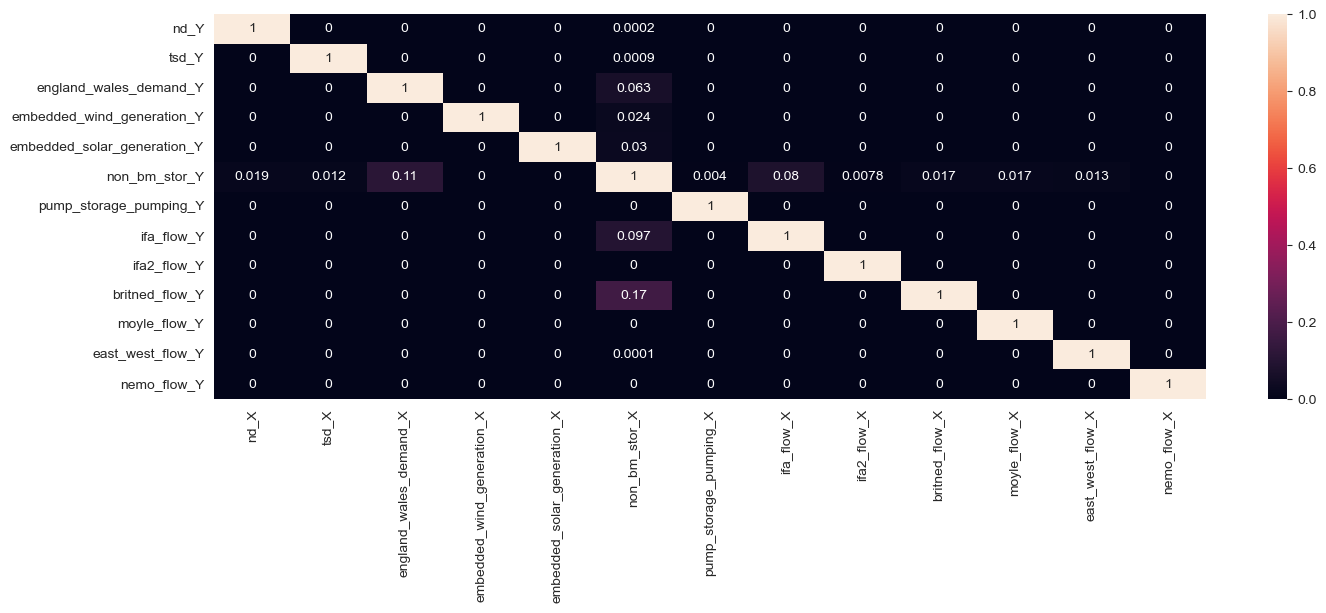

In [35]:
df_granger = grangers_test(df_diff_1, maxlag, variables = df_diff_1.columns)
plt.figure(figsize = (16,5))
sns.heatmap(df_granger, annot = True)

In [30]:
df_diff_1 = df_diff_1.drop('non_bm_stor', axis = 1)

In [31]:
df_pour_var = df_pour_var.drop('non_bm_stor', axis = 1)

<Axes: >

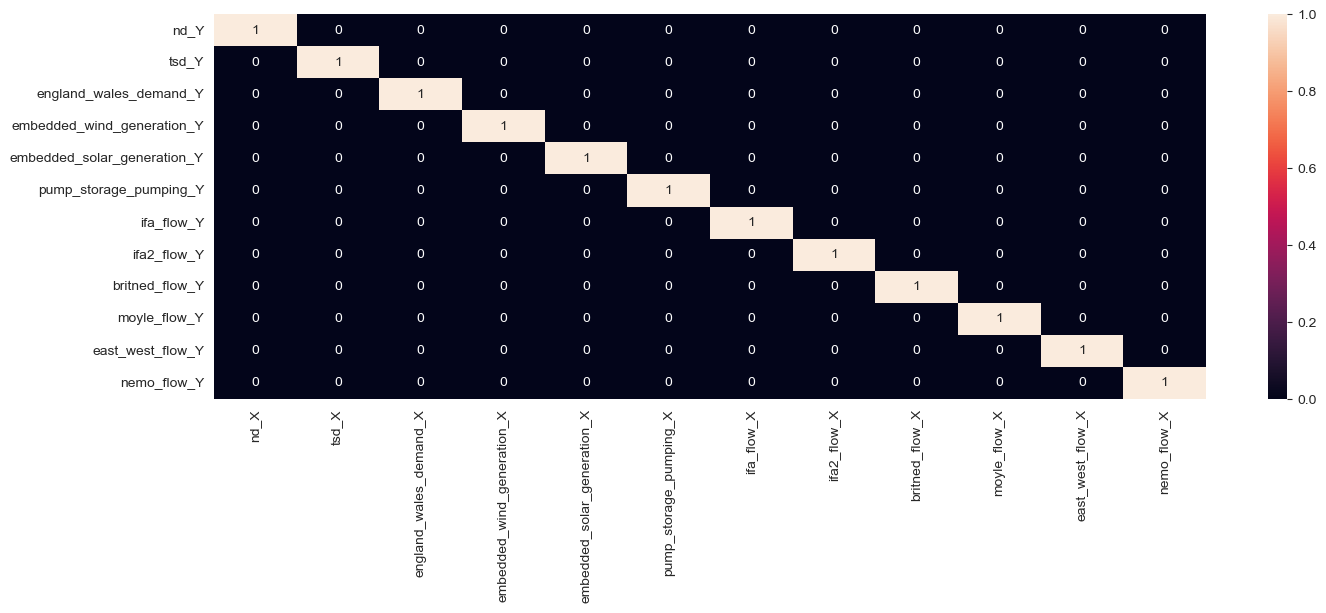

In [37]:
df_granger = grangers_test(df_diff_1, maxlag, variables = df_diff_1.columns)
plt.figure(figsize = (16,5))
sns.heatmap(df_granger, annot = True)

In [32]:
train_var = df_diff_1[:-n_period_predict]
test_var = df_diff_1[-n_period_predict:]

In [43]:
maxlag = 48*7

In [44]:
train_var.values[-maxlag:].shape

(336, 12)

In [45]:
model_var = VAR(endog = train_var)

C:\Users\vdistefano\Anaconda3\envs\VAR\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


# iter predict par lag

In [ ]:
lag = maxlag #On choisi le lag max
array_mae_var = []
array_pvalue_normal = []
array_pvalue_whiteness = []
array_df_predit = []
for i in range(48, lag, 48):
    df_predit_var, var_MAE, pvalue_normality, pvalue_whiteness = pipeline_var(model_var, train_var, test_var, i, df_pour_var, n_period_predict, cible= variable_cible.name)
    array_df_predit.append(df_predit_var)
    array_mae_var.append(var_MAE)
    array_pvalue_normal.append(pvalue_normality)
    array_pvalue_whiteness.append(pvalue_whiteness)
    print(f"la mae est de {var_MAE}")
    print(i)

la mae est de 38174.05875313509
48
la mae est de 38461.07047127249
96
la mae est de 38461.07047127249
144
la mae est de 38461.07047127249
192


In [ ]:
print(min(array_mae_var))

In [ ]:
item_index = np.where(array_mae_var == min(array_mae_var))[0]

# Entraînement final

In [37]:
model_var = VAR(endog = train_var)
model_fitted_var = model_var.fit(48, ic = "aic")
result_normality = model_fitted_var.test_normality().pvalue #"H0 : les données suivent une loi normale. Si p-value <0.05, on rejette
result_whiteness = model_fitted_var.test_whiteness(round((len(train_var) + len(test_var))/5)).pvalue

lag_order = model_fitted_var.k_ar
input_data = train_var.values[-lag_order:]
y_predicted = model_fitted_var.forecast(y = input_data, steps = len(test_var))

df_predicted = pd.DataFrame(y_predicted, index=test_var.index, columns=train_var.columns)

df_true_results = inv_diff(df_pour_var, df_predicted, n_period_predict)

C:\Users\vdistefano\Anaconda3\envs\VAR\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [39]:
MAE_var = mean_absolute_error(df_pour_var[variable_cible.name].iloc[-n_period_predict:], df_true_results[variable_cible.name+'_forecast'])
print(f"La MAE du modèle sur la variable cible vaut {MAE_var}")

La MAE du modèle sur la variable cible vaut 2837.3007282907165


In [40]:
columns = df_pour_var.columns

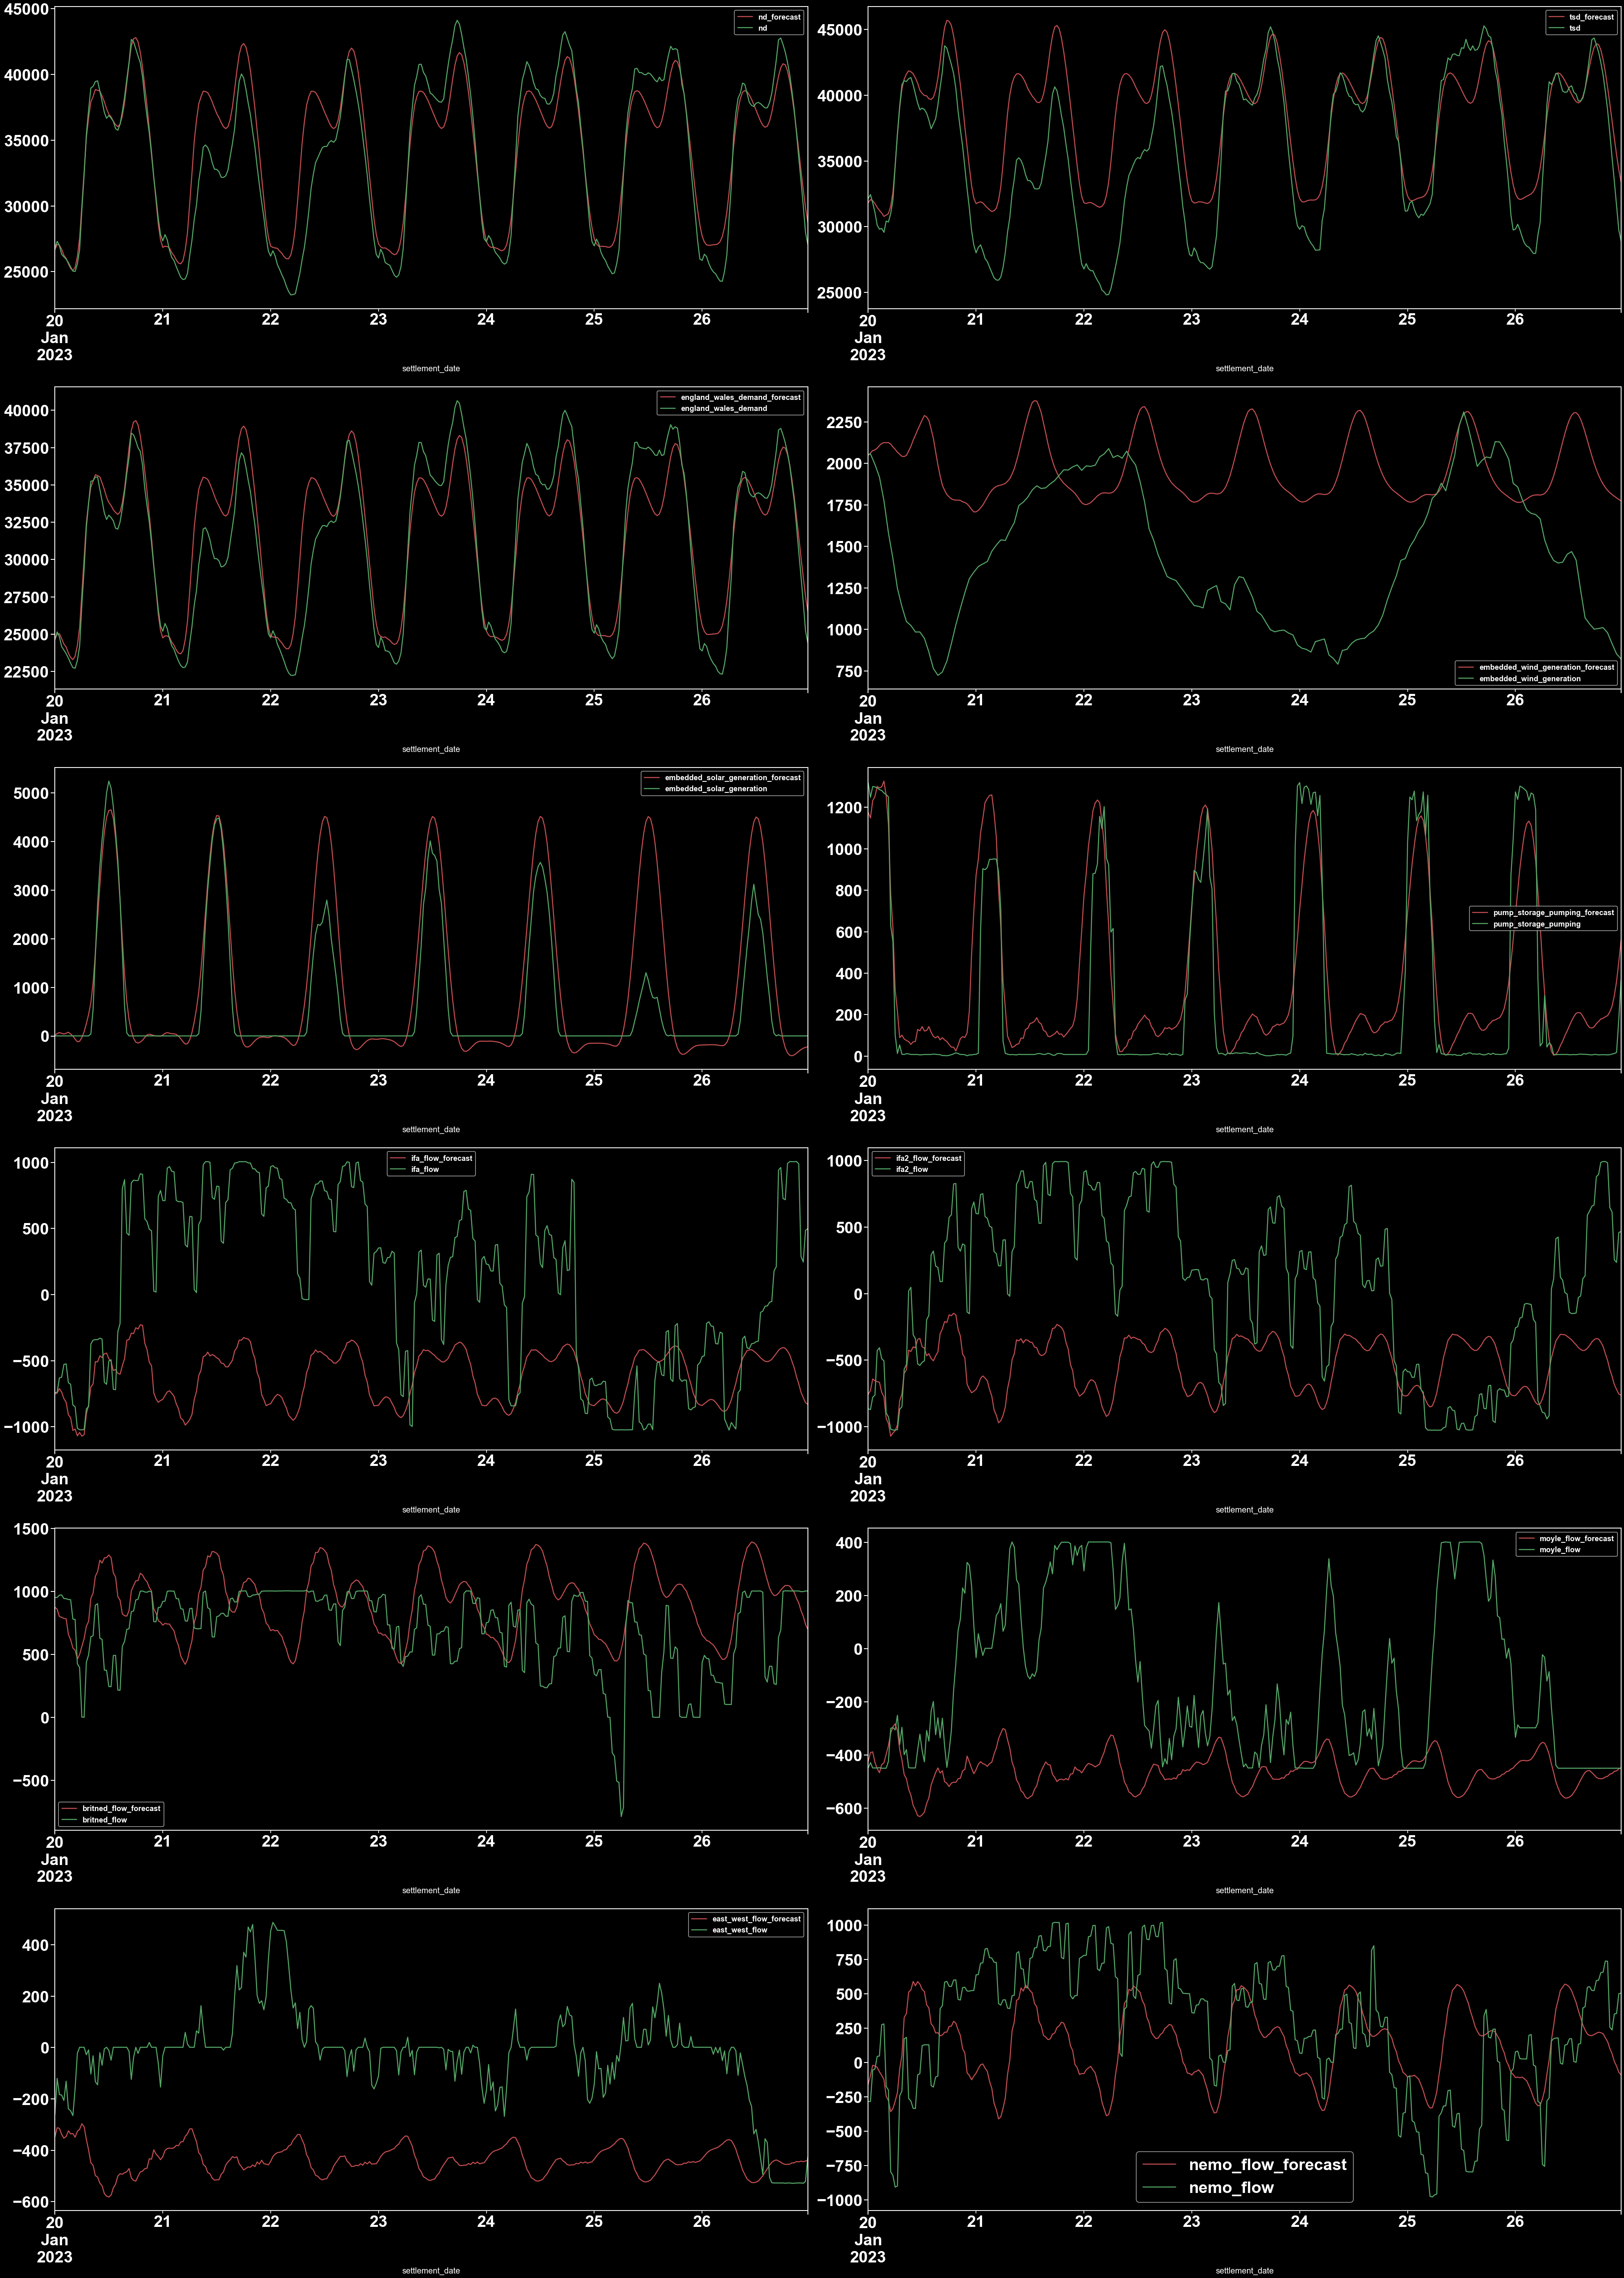

In [41]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 34}

plt.rc('font', **font)
sns.set(style="ticks", context="talk")
plt.style.use("dark_background")
fig, axes = plt.subplots(6,2, figsize=(50,70), dpi = 80)
df_true_results[columns+'_forecast'].plot(subplots=True, ax = axes, color = 'r', fontsize = 36, legend = True)
df_pour_var[-n_period_predict:].plot(subplots=True, ax = axes, color = 'g', fontsize = 36, legend = True)
#fig.legend(fontsize=20)
plt.legend(fontsize = 36)
plt.tight_layout()
plt.show()

# sauvegarde du modèle

In [ ]:
model_save = model_fitted_var
def save_model(name, model):
    with open(f"{name}.pkl", "wb") as f:
        pickle.dump(model, f)


filename = 'modele_var_projet_mle_21032023.sav'
save_model('modele_var_projet_mle_21032023', model_save)
joblib.dump(model_save, 'modele_var_projet_mle_21032023.pkl')